In [ ]:
!git clone https://github.com/nazianafis/Neural-Style-Transfer.git

Cloning into 'Neural-Style-Transfer'...
remote: Enumerating objects: 379, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 379 (delta 72), reused 105 (delta 34), pack-reused 225 (from 1)
Receiving objects: 100% (379/379), 92.21 MiB | 13.72 MiB/s, done.
Resolving deltas: 100% (143/143), done.


In [ ]:
%cd Neural-Style-Transfer

/content/Neural-Style-Transfer


In [ ]:
import cv2 as cv
import numpy as np
import torch
from torchvision import transforms
from torch.autograd import Variable
from torch.optim import LBFGS
import os
import matplotlib.pyplot as plt

from models.definitions.vgg19 import Vgg19 # a pre-trained VGG-19 model

# Standardize Input Image

**VGG-19** was trained on the **ImageNet** dataset, where all images were normalized using fixed RGB channel statistics.
To make the input images compatible with this pretrained model, we need to apply the same normalization, so as to ensure VGG-19 extracts stable and meaningful content and style features.

* `IMAGENET_MEAN_255` contains the ImageNet RGB means (scaled to 0-255). Subtracting these values shifts our input into the distribution expected by VGG-19.

* `IMAGENET_STD_NEUTRAL = [1,1,1]` means we only subtract the mean without dividing by a standard deviation.
This preserves the original contrast of the image, which is often preferred for style transfer.


In [ ]:
IMAGENET_MEAN_255 = [123.675, 116.28, 103.53]
IMAGENET_STD_NEUTRAL = [1, 1, 1]

In [ ]:
loss_history = []
content_loss_history = []
style_loss_history = []
tv_loss_history = []

# Image I/O & Save intermediate results

In [ ]:
def load_image(img_path,target_shape="None"):
    '''
    Load and resize the image.
    '''
    if not os.path.exists(img_path):
        raise Exception(f'Path not found: {img_path}')
    img = cv.imread(img_path)[:, :, ::-1]   # BGR -> RGB
    if target_shape is not None:
        if isinstance(target_shape, int) and target_shape != -1:
            current_height, current_width = img.shape[:2]
            new_height = target_shape
            new_width = int(current_width * (new_height / current_height))
            img = cv.resize(img, (new_width, new_height), interpolation=cv.INTER_CUBIC)
        else:
            img = cv.resize(img, (target_shape[1], target_shape[0]), interpolation=cv.INTER_CUBIC)
    img = img.astype(np.float32)
    img /= 255.0
    return img

In [ ]:
def prepare_img(img_path, target_shape, device):
    '''
    Normalize the image.
    '''
    img = load_image(img_path, target_shape=target_shape)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255)),
        transforms.Normalize(mean=IMAGENET_MEAN_255, std=IMAGENET_STD_NEUTRAL)])
    img = transform(img).to(device).unsqueeze(0)
    return img

In [ ]:
def save_image(img, img_path):
    if len(img.shape) == 2:
        img = np.stack((img,) * 3, axis=-1)
    cv.imwrite(img_path, img[:, :, ::-1])  # RGB -> BGR

In [ ]:
def generate_out_img_name(config):
    '''
    Generate a name for the output image.
    Example: 'c1-s1.jpg'
    where c1: content_img_name, and
          s1: style_img_name.
    '''
    prefix = os.path.basename(config['content_img_name']).split('.')[0] + '_' + os.path.basename(config['style_img_name']).split('.')[0]
    suffix = f'{config["img_format"][1]}'
    return prefix + suffix

In [ ]:
def save_and_maybe_display(optimizing_img, dump_path, config, img_id, num_of_iterations):
    '''
    Save the generated image.
    If saving_freq == -1, only the final output image will be saved.
    Else, intermediate images can be saved too.
    '''
    saving_freq = -1
    out_img = optimizing_img.squeeze(axis=0).to('cpu').detach().numpy()
    out_img = np.moveaxis(out_img, 0, 2)

    if img_id == num_of_iterations-1 :
        img_format = config['img_format']
        out_img_name = str(img_id).zfill(img_format[0]) + img_format[1] if saving_freq != -1 else generate_out_img_name(config)
        dump_img = np.copy(out_img)
        dump_img += np.array(IMAGENET_MEAN_255).reshape((1, 1, 3))
        dump_img = np.clip(dump_img, 0, 255).astype('uint8')
        cv.imwrite(os.path.join(dump_path, out_img_name), dump_img[:, :, ::-1])

# Model & loss-related functions

In [ ]:
def prepare_model(device):
    '''
    Load VGG19 model into local cache.
    '''
    model = Vgg19(requires_grad=False, show_progress=True)
    content_feature_maps_index = model.content_feature_maps_index
    style_feature_maps_indices = model.style_feature_maps_indices
    layer_names = model.layer_names
    content_fms_index_name = (content_feature_maps_index, layer_names[content_feature_maps_index])
    style_fms_indices_names = (style_feature_maps_indices, layer_names)
    return model.to(device).eval(), content_fms_index_name, style_fms_indices_names

In [ ]:
def gram_matrix(x, should_normalize=True):
    '''
    Generate gram matrices of the representations of content and style images.
    '''
    (b, ch, h, w) = x.size()
    features = x.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t)
    if should_normalize:
        gram /= ch * h * w
    return gram

In [ ]:
def total_variation(y):
    '''
    Calculate total variation.
    '''
    return torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:])) + torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :]))

In [ ]:
def build_loss(neural_net, optimizing_img, target_representations, content_feature_maps_index, style_feature_maps_indices, config):
    '''
    Calculate content_loss, style_loss, and total_variation_loss.
    '''
    target_content_representation = target_representations[0]
    target_style_representation = target_representations[1]
    current_set_of_feature_maps = neural_net(optimizing_img)
    current_content_representation = current_set_of_feature_maps[content_feature_maps_index].squeeze(axis=0)
    content_loss = torch.nn.MSELoss(reduction='mean')(target_content_representation, current_content_representation)
    style_loss = 0.0
    current_style_representation = [gram_matrix(x) for cnt, x in enumerate(current_set_of_feature_maps) if cnt in style_feature_maps_indices]
    for gram_gt, gram_hat in zip(target_style_representation, current_style_representation):
        style_loss += torch.nn.MSELoss(reduction='sum')(gram_gt[0], gram_hat[0])
    style_loss /= len(target_style_representation)
    tv_loss = total_variation(optimizing_img)
    total_loss = config['content_weight'] * content_loss + config['style_weight'] * style_loss + config['tv_weight'] * tv_loss
    return total_loss, content_loss, style_loss, tv_loss

In [ ]:
def make_tuning_step(neural_net, optimizer, target_representations, content_feature_maps_index, style_feature_maps_indices, config):
    '''
    Performs a step in the tuning loop.
    (We are tuning only the pixels, not the weights.)
    '''
    def tuning_step(optimizing_img):
        total_loss, content_loss, style_loss, tv_loss = build_loss(neural_net, optimizing_img, target_representations, content_feature_maps_index, style_feature_maps_indices, config)
        total_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        return total_loss, content_loss, style_loss, tv_loss
    return tuning_step

# Main NST Function

In [ ]:
def neural_style_transfer(config):
    '''
    The main Neural Style Transfer method.
    '''
    global loss_history, content_loss_history, style_loss_history, tv_loss_history

    # Clear the old records instead of recreating the variables
    loss_history.clear()
    content_loss_history.clear()
    style_loss_history.clear()
    tv_loss_history.clear()

    content_img_path = os.path.join(config['content_images_dir'], config['content_img_name'])
    style_img_path = os.path.join(config['style_images_dir'], config['style_img_name'])

    out_dir_name = 'combined_' + os.path.split(content_img_path)[1].split('.')[0] + '_' + \
                   os.path.split(style_img_path)[1].split('.')[0]
    dump_path = os.path.join(config['output_img_dir'], out_dir_name)
    os.makedirs(dump_path, exist_ok=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    content_img = prepare_img(content_img_path, config['height'], device)
    style_img = prepare_img(style_img_path, config['height'], device)

    init_img = content_img
    optimizing_img = Variable(init_img, requires_grad=True)

    neural_net, content_feature_maps_index_name, style_feature_maps_indices_names = prepare_model(device)
    print(f'Using VGG19 in the optimization procedure.')

    content_img_set_of_feature_maps = neural_net(content_img)
    style_img_set_of_feature_maps = neural_net(style_img)

    target_content_representation = content_img_set_of_feature_maps[content_feature_maps_index_name[0]].squeeze(axis=0)
    target_style_representation = [gram_matrix(x) for cnt, x in enumerate(style_img_set_of_feature_maps)
                                   if cnt in style_feature_maps_indices_names[0]]
    target_representations = [target_content_representation, target_style_representation]

    num_of_iterations = 300 # The original setting is 1000 and can be modified as needed

    optimizer = LBFGS((optimizing_img,), max_iter=num_of_iterations, line_search_fn='strong_wolfe')
    cnt = 0

    def closure():
        nonlocal cnt
        global loss_history, content_loss_history, style_loss_history, tv_loss_history

        if torch.is_grad_enabled():
            optimizer.zero_grad()

        total_loss, content_loss, style_loss, tv_loss = build_loss(
            neural_net, optimizing_img, target_representations,
            content_feature_maps_index_name[0], style_feature_maps_indices_names[0], config
        )

        if total_loss.requires_grad:
            total_loss.backward()

        with torch.no_grad():
            # New addition: Record the loss for each closure
            loss_history.append(total_loss.item())
            content_loss_history.append(content_loss.item())
            style_loss_history.append(style_loss.item())
            tv_loss_history.append(tv_loss.item())

            print(
                f'L-BFGS | iteration: {cnt:03}, '
                f'total loss={total_loss.item():12.4f}, '
                f'content_loss={config["content_weight"] * content_loss.item():12.4f}, '
                f'style loss={config["style_weight"] * style_loss.item():12.4f}, '
                f'tv loss={config["tv_weight"] * tv_loss.item():12.4f}'
            )
            save_and_maybe_display(optimizing_img, dump_path, config, cnt, num_of_iterations)

        cnt += 1
        return total_loss

    optimizer.step(closure)
    return dump_path


# Configure & run NST

In [ ]:
PATH = ''
CONTENT_IMAGE = 'pet.jpg'
STYLE_IMAGE = 's2.jpg'

In [ ]:
default_resource_dir = os.path.join(PATH, 'data')
content_images_dir = os.path.join(default_resource_dir, 'content-images')
style_images_dir = os.path.join(default_resource_dir, 'style-images')
output_img_dir = os.path.join(default_resource_dir, 'output-images')
img_format = (4, '.jpg')

In [ ]:
optimization_config = {'content_img_name': CONTENT_IMAGE, 'style_img_name': STYLE_IMAGE, 'height': 400, 'content_weight': 100000.0, 'style_weight': 30000.0, 'tv_weight': 1.0}
optimization_config['content_images_dir'] = content_images_dir
optimization_config['style_images_dir'] = style_images_dir
optimization_config['output_img_dir'] = output_img_dir
optimization_config['img_format'] = img_format

In [ ]:
results_path = neural_style_transfer(optimization_config)


Using VGG19 in the optimization procedure.
L-BFGS | iteration: 000, total loss=10994220793856.0000, content_loss=      0.0000, style loss=10994214720000.0000, tv loss=6593630.0000
L-BFGS | iteration: 001, total loss=10994217648128.0000, content_loss=      0.0010, style loss=10994210880000.0000, tv loss=6593631.0000
L-BFGS | iteration: 002, total loss=10994216599552.0000, content_loss=      0.0027, style loss=10994209920000.0000, tv loss=6593632.0000
L-BFGS | iteration: 003, total loss=10994193530880.0000, content_loss=      0.0727, style loss=10994186880000.0000, tv loss=6593641.0000
L-BFGS | iteration: 004, total loss=10994144247808.0000, content_loss=      0.5351, style loss=10994137920000.0000, tv loss=6593660.5000
L-BFGS | iteration: 005, total loss=10994075041792.0000, content_loss=      2.0386, style loss=10994068800000.0000, tv loss=6593689.0000
L-BFGS | iteration: 006, total loss=10993417584640.0000, content_loss=     61.5047, style loss=10993411200000.0000, tv loss=6593955.000

The LBFGS optimizer calls the closure function multiple times per iteration for line search, so the printed iteration counter may exceed the value of max_iter, even though the actual optimization steps are bounded by max_iter.

# Plot loss curves

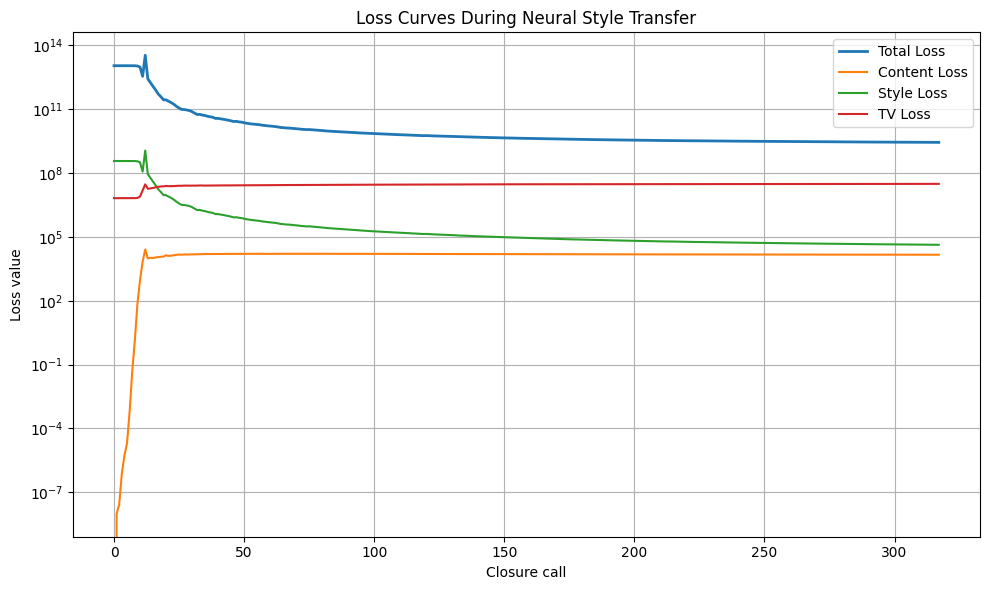

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(loss_history, label="Total Loss", linewidth=2)
plt.plot(content_loss_history, label="Content Loss")
plt.plot(style_loss_history, label="Style Loss")
plt.plot(tv_loss_history, label="TV Loss")

plt.xlabel("Closure call")
plt.ylabel("Loss value")
plt.title("Loss Curves During Neural Style Transfer")
plt.yscale("log")  # Use logarithmic coordinates to show the four curves more clearly in one picture
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
